In [15]:
from scipy.io import wavfile

#the first is the sampling rate in samples per second, 
#the second is a numpy array with all the data read from the file:
samplerate, data = wavfile.read('./input/demo.wav')

WAV file in:  Fs = 44100, x.shape = (441000,), x.dtype = int16


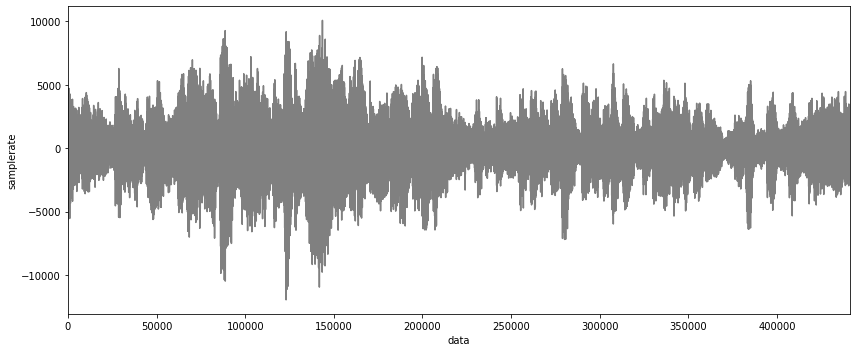

In [16]:
import os
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa
import pandas as pd
%matplotlib inline

def print_plot_play(x, Fs, text=''):
    
    print('%s Fs = %d, x.shape = %s, x.dtype = %s' % (text, Fs, x.shape, x.dtype))
    plt.figure(figsize=(12, 5))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('data')
    plt.ylabel('samplerate')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs))

    
print_plot_play(x=data, Fs=samplerate, text='WAV file in: ')

In [17]:
import numpy as np

with open('text.txt', 'r') as fid:
    data_array = np.fromfile(fid, np.uint8) # converting the text to uint8 (byte) array

print(data_array)
#textbase8 = np.uint8(data_array)

#arr = np.ndarray.tostring((data_array))
#np.unpackbits(arr)

[ 83 101  99 114 101 116  32 109 115 103  10]


In [18]:
with open("text.txt") as f:
    content = f.read()

print(list(content))

textdatatype = list(content)


['S', 'e', 'c', 'r', 'e', 't', ' ', 'm', 's', 'g', '\n']


In [19]:
def getBits(data_array):
    
    matrix = np.unpackbits(data_array) #dec2bin
    return(np.reshape(np.transpose(matrix),1*8*len(data_array),order = "C")) #reshape transpose matrix


#scratchpad
#import csv 
#with open('testcsv', 'w') as f: 
      
    # using csv.writer method from CSV package 
    #write = csv.writer(f) 
      
   # write.writerow(data) 
    #write.writerows(rows) 
#print(np.unpackbits(data_array))
print(data[:])

# using the savetxt  
# from the numpy module 
#np.savetxt("hello.csv",  
           #data, 
           #delimiter =", ",  
           #fmt ='% s')


[-5616 -5500 -5365 ... -1131 -1006  -877]


In [20]:
import math
from scipy.fft import fft, ifft

def phase_encoder(data,data_array):

    L = 1024
    plain =  data[:]
    datafrombits = getBits(data_array)
    I = len(plain)
    m = len(datafrombits)
    N = math.floor(I/L)
    s = np.reshape(plain[:N*L,], L*N, order="C")
    w = fft(s)            # FFT of each segment
    Phi = np.angle(w)
    Phi_New = np.angle(w)  # Phases matrix including each segment
    A = abs(w)         
    

    #Calculating phase differences of adjacent segments
    
    DeltaPhi = np.zeros((L,N))
    
    
    for k in range(2, N):
        DeltaPhi[k] = Phi[k]-Phi[k-1]
        
    #Binary data is represented as {-pi/2, pi/2} and stored in PhiData

    
    PhiData = np.zeros((1,m-1))
    
    for k in range(1, m-1):
        if(datafrombits[k] == '0'):
            PhiData[k] = math.pi/2
        elif(datafrombits[k] == '1'):
            PhiData[k] = -math.pi/2

    
    #PhiData into the middle of first phase matrix
    
    Phi_New[:] = Phi[:]
    Phi_New[math.floor(L/2-m+1):math.floor(L/2),] = PhiData;        
    Phi_New[math.floor(L/2+1+1):math.floor(L/2+1+m),] = -np.flip(PhiData); 
    
    
    #Reconstruct signal in time domain using ifft
    
    z = np.real(ifft((A * np.exp(1j*Phi_New)))) #Euler's formula
    snew = np.reshape(z, N*L*1, order="C")
    snew = snew + plain[1:N*L+1:]
    return(snew)

In [21]:
from scipy.io.wavfile import write
# to be added at end
#out = phase_encoder(data, data_array)

output = phase_encoder(data,data_array)

write("embeddedstego.wav", samplerate, output)


WAV file out:  Fs = 44100, x.shape = (440320,), x.dtype = float64


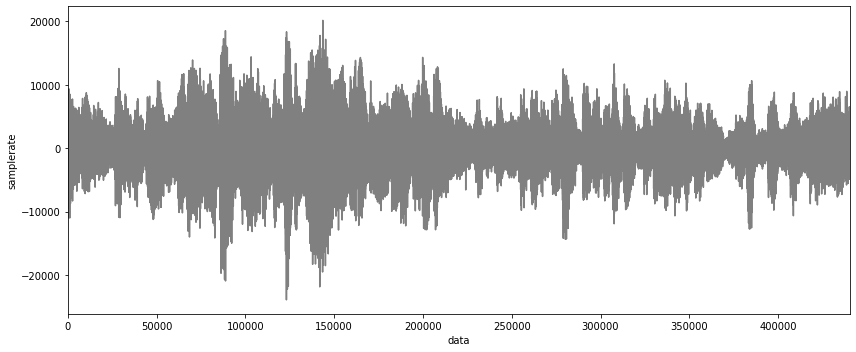

In [22]:
#display audio output file
samplerate2, data2 = wavfile.read('embeddedstego.wav')

print_plot_play(x=data2, Fs=samplerate2, text='WAV file out: ')

In [37]:
#testing
#print(str(getBits(np.uint8(data_array))))
#print(str(msg))
def bit_err(hidden,extracted):
    y = str(getBits(np.uint8(hidden)))
    x = str(extracted)
    
    l = min(len(x),len(y))
    
    ber = 0
    for i in range(1,l):
        err = (x[i] >= y[i])
        ber = ber + err

    return(ber/l)

In [44]:
def phase_decoder(data,data_array):
    L = int(len(data_array))
    m = 8*L
    x = data[:]
    Phi = np.angle(fft(x))
    
    dataseq = np.zeros((1,m))
    
    for k in range(1,m):
        if(Phi[int(L/2-m+k)]>0):
            dataseq[0,k] = '0'
        else:
            dataseq[0,k] = '1'
        
    binary = np.transpose(np.reshape(dataseq[0:m],8*(m//8), order="C"))
    conv2int = binary
    typeint = conv2int.astype(int)
    return(typeint)

In [78]:
msg = phase_decoder(data, data_array)

err = bit_err(data_array,msg)

print(err)


0.888268156424581


In [76]:
#print the decoded message as bits
msg2 = str(msg)
msg3 = msg2.strip('[]')
msg3 = msg3.replace(' ','')
msg3 = msg3.replace('\n','')
print(msg3)


0101101101101110101111010110110101001101000100110110111111010011111000100010100101110101


In [81]:
#now divide the bits obtained in previous step into blocks of size 8 and then print each of these block's 
#ASCII value 
#this gives the decoded message

string_blocks = (msg3[i:i+8] for i in range(0, len(msg3), 8))
string = ''.join(chr(int(char, 2)) for char in string_blocks)

print(string)

[n½mMoÓâ)u
